**TABLE OF CONTENTS**  

**1. Data Wrangling**  
    1.1. Data Collection  
    1.2. Data Cleaning    
*         1.2.1. Detecting Missing Values  
*         1.2.2. Dealing With Missing Values  
*         1.2.3. Dealing With Data Types  
        
**2. Advanced Data Analytics**  
    2.1. Summary  
    2.2. Histogram  
    2.3. Correlation Matrix

**3. Streaming Prediction ( Random Forest )**  
    3.1. With Default Hyperparameters  
    3.2. With Best Hyperparameters(via GridSearch)  
*         3.2.1. Evaluation
*         3.2.2. Feature Importances  
*         3.2.3. Actual vs. Predicted Streams
*         3.2.4. Residiual vs. Predicted Streams  
*         3.2.5. Distribution of Streams  
        
    


****Libraries****

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV

**Stage 1: Data Wrangling**

**Stage 1.1: Data Collection**

In [2]:
data = pd.read_csv('/kaggle/input/top-spotify-songs-2023/spotify-2023.csv',encoding='ISO-8859-1')
data.head()

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,...,125,B,Major,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,...,92,C#,Major,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,...,138,F,Major,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,...,170,A,Major,55,58,72,11,0,11,15
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,...,144,A,Minor,65,23,80,14,63,11,6


In [3]:
# Listing the columns of the DataFrame
columns = data.columns.tolist()
print("\nColumns in the DataFrame:")
print(columns)


Columns in the DataFrame:
['track_name', 'artist(s)_name', 'artist_count', 'released_year', 'released_month', 'released_day', 'in_spotify_playlists', 'in_spotify_charts', 'streams', 'in_apple_playlists', 'in_apple_charts', 'in_deezer_playlists', 'in_deezer_charts', 'in_shazam_charts', 'bpm', 'key', 'mode', 'danceability_%', 'valence_%', 'energy_%', 'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%']


**Stage 1.2: Data Cleaning**

**Stage 1.2.1: Detecting Missing Values**

In [4]:
# Checking for missing values in each column
missing_values = data.isnull().sum()
print(missing_values)


track_name               0
artist(s)_name           0
artist_count             0
released_year            0
released_month           0
released_day             0
in_spotify_playlists     0
in_spotify_charts        0
streams                  0
in_apple_playlists       0
in_apple_charts          0
in_deezer_playlists      0
in_deezer_charts         0
in_shazam_charts        50
bpm                      0
key                     95
mode                     0
danceability_%           0
valence_%                0
energy_%                 0
acousticness_%           0
instrumentalness_%       0
liveness_%               0
speechiness_%            0
dtype: int64


**Stage 1.2.2: Dealing With Missing Values**

**in_shazam_charts:**

**Analysis:** Since this represents a ranking on the Shazam charts, missing values likely indicate that the song didn't achieve a rank.

**Our Strategy:** We opted to handle the missing data in two ways:

1. For interpretability, we created a copy of the column and filled missing values with a "Not Ranked" placeholder. This maintains clarity for anyone inspecting the dataset manually.
2. For machine learning readiness, another copy of the column was made. Here, missing values are replaced with a numerical value (max_rank + 1). This ensures models receive purely numerical input without losing the information that these songs weren't ranked.  

This dual approach retains the integrity of the original data while making it usable for various analytical purposes.

In [5]:
# Create a copy for human-readable data
data['in_shazam_charts_readable'] = data['in_shazam_charts']

# Remove commas from the original column and convert to float
data['in_shazam_charts'] = data['in_shazam_charts'].replace({',': ''}, regex=True).astype(float)

# Create another copy for ML processing
data['in_shazam_charts_forML'] = data['in_shazam_charts'].copy()

# Find the max rank
max_rank = data['in_shazam_charts_forML'].max()

# In the 'readable' version, replace NaN with "Not Ranked"
data['in_shazam_charts_readable'].fillna("Not Ranked", inplace=True)

# In the 'forML' version, replace NaN with max_rank + 1
data['in_shazam_charts_forML'].fillna(max_rank + 1, inplace=True)

# Drop the original 'in_shazam_charts' column
data.drop('in_shazam_charts', axis=1, inplace=True)




In [6]:
data['in_shazam_charts_forML'] = data['in_shazam_charts_forML'].astype(int)


**key:** 

**Analysis:** This attribute signifies the musical key in which the song is composed. Assigning mean, median, or mode might be inappropriate and potentially misleading unless the missing values occur randomly without a discernable pattern.

**Our Strategy:** Given the nature of the 'key' attribute and considering its importance in our analysis, we have decided to remove the rows with missing key values to maintain the integrity and quality of our dataset. This approach ensures that we're working with complete data for each song in our subsequent analyses.

In [7]:
# Remove the rows with missing 'key' values
data = data.dropna(subset=['key'])

# Verify if the rows with missing values have been removed
print("Missing values after removal:", data['key'].isnull().sum())

Missing values after removal: 0


**Stage 1.2.3: Dealing With DataTypes**

In [8]:
# Inspect current data types
print("Original Data Types:")
print(data.dtypes)

Original Data Types:
track_name                   object
artist(s)_name               object
artist_count                  int64
released_year                 int64
released_month                int64
released_day                  int64
in_spotify_playlists          int64
in_spotify_charts             int64
streams                      object
in_apple_playlists            int64
in_apple_charts               int64
in_deezer_playlists          object
in_deezer_charts              int64
bpm                           int64
key                          object
mode                         object
danceability_%                int64
valence_%                     int64
energy_%                      int64
acousticness_%                int64
instrumentalness_%            int64
liveness_%                    int64
speechiness_%                 int64
in_shazam_charts_readable    object
in_shazam_charts_forML        int64
dtype: object


In [9]:
# Combine 'released_year', 'released_month', and 'released_day' into a single datetime column
data['release_date'] = pd.to_datetime(data['released_year'].astype(str) + '-' + 
                                      data['released_month'].astype(str) + '-' + 
                                      data['released_day'].astype(str), errors='coerce')

# Check the new 'release_date' column
print(data['release_date'].head())

0   2023-07-14
1   2023-03-23
2   2023-06-30
3   2019-08-23
4   2023-05-18
Name: release_date, dtype: datetime64[ns]


In [10]:
# Convert 'streams', 'in_deezer_playlists' to appropriate numerical or categorical data types
data['streams'] = pd.to_numeric(data['streams'], errors='coerce')
data['in_deezer_playlists'] = pd.to_numeric(data['in_deezer_playlists'], errors='coerce')

In [11]:
# Inspect revised data types
print("Revised Data Types:")
print(data.dtypes)

Revised Data Types:
track_name                           object
artist(s)_name                       object
artist_count                          int64
released_year                         int64
released_month                        int64
released_day                          int64
in_spotify_playlists                  int64
in_spotify_charts                     int64
streams                             float64
in_apple_playlists                    int64
in_apple_charts                       int64
in_deezer_playlists                 float64
in_deezer_charts                      int64
bpm                                   int64
key                                  object
mode                                 object
danceability_%                        int64
valence_%                             int64
energy_%                              int64
acousticness_%                        int64
instrumentalness_%                    int64
liveness_%                            int64
speechiness_

In [12]:
print("Number of missing values in 'streams':", data['streams'].isna().sum())
print("Number of missing values in 'in_deezer_playlists':", data['in_deezer_playlists'].isna().sum())


Number of missing values in 'streams': 1
Number of missing values in 'in_deezer_playlists': 75


In [13]:
print(data[data['streams'].isna()])


                              track_name     artist(s)_name  artist_count  \
574  Love Grows (Where My Rosemary Goes)  Edison Lighthouse             1   

     released_year  released_month  released_day  in_spotify_playlists  \
574           1970               1             1                  2877   

     in_spotify_charts  streams  in_apple_playlists  ...  danceability_%  \
574                  0      NaN                  16  ...              53   

     valence_%  energy_%  acousticness_% instrumentalness_% liveness_%  \
574         75        69               7                  0         17   

     speechiness_%  in_shazam_charts_readable  in_shazam_charts_forML  \
574              3                          0                       0   

     release_date  
574    1970-01-01  

[1 rows x 26 columns]


In [14]:
# Remove the row with NaN value in 'streams' column
data = data.dropna(subset=['streams'])

# Verify if the row has been removed
print("Number of missing values in 'streams':", data['streams'].isna().sum())


Number of missing values in 'streams': 0


In [15]:
print(data[data['in_deezer_playlists'].isna()].head())



         track_name         artist(s)_name  artist_count  released_year  \
48          Starboy  The Weeknd, Daft Punk             2           2016   
54     Another Love              Tom Odell             1           2012   
55  Blinding Lights             The Weeknd             1           2019   
65           Yellow          Chris Molitor             1           1999   
73  Sweater Weather      The Neighbourhood             1           2012   

    released_month  released_day  in_spotify_playlists  in_spotify_charts  \
48               9            21                 29536                 79   
54              10            15                 18371                 83   
55              11            29                 43899                 69   
65               1             1                 31358                 43   
73               5            14                 16413                 61   

         streams  in_apple_playlists  ...  danceability_%  valence_%  \
48  2.565530e+

In [16]:
data['in_deezer_playlists'].fillna(0, inplace=True)


In [17]:
# Inspect revised data types
print("Revised Data Types:")
print(data.dtypes)

Revised Data Types:
track_name                           object
artist(s)_name                       object
artist_count                          int64
released_year                         int64
released_month                        int64
released_day                          int64
in_spotify_playlists                  int64
in_spotify_charts                     int64
streams                             float64
in_apple_playlists                    int64
in_apple_charts                       int64
in_deezer_playlists                 float64
in_deezer_charts                      int64
bpm                                   int64
key                                  object
mode                                 object
danceability_%                        int64
valence_%                             int64
energy_%                              int64
acousticness_%                        int64
instrumentalness_%                    int64
liveness_%                            int64
speechiness_

*Why Convert to Numeric Before Integer?*  

We first use pd.to_numeric() before converting data to integers to handle non-numeric values effectively. This two-step process ensures that any non-numeric values are converted to NaNs, preventing potential errors during the integer conversion. It adds robustness and flexibility, allowing for easier handling of missing or unexpected values before final data type conversion.

In [18]:
# We're ensuring the original 'mode' and 'key' columns remain unchanged and creating new encoded columns for them

# One-Hot Encoding for 'mode' while keeping the original 'mode' column untouched
# Creating a DataFrame of one-hot encoded values
mode_encoded = pd.get_dummies(data['mode'], prefix='mode')

# Concatenating the one-hot encoded DataFrame to the original DataFrame
data = pd.concat([data, mode_encoded], axis=1)

# Label Encoding for 'key' while keeping the original 'key' column untouched
# Initiating the label encoder
label_encoder = LabelEncoder()

# Creating a new column for encoded 'key' values
data['key_encoded'] = label_encoder.fit_transform(data['key'].astype(str))

# Print updated DataFrame with new encoded columns alongside original 'mode' and 'key'
print("\nUpdated Data with Encoded Categorical Variables:")
print(data[['mode', *mode_encoded.columns, 'key', 'key_encoded']].head())


Updated Data with Encoded Categorical Variables:
    mode  mode_Major  mode_Minor key  key_encoded
0  Major        True       False   B            2
1  Major        True       False  C#            3
2  Major        True       False   F            7
3  Major        True       False   A            0
4  Minor       False        True   A            0


In [19]:
# Inspect revised data types again
print("Revised Data Types:")
print(data.dtypes)

Revised Data Types:
track_name                           object
artist(s)_name                       object
artist_count                          int64
released_year                         int64
released_month                        int64
released_day                          int64
in_spotify_playlists                  int64
in_spotify_charts                     int64
streams                             float64
in_apple_playlists                    int64
in_apple_charts                       int64
in_deezer_playlists                 float64
in_deezer_charts                      int64
bpm                                   int64
key                                  object
mode                                 object
danceability_%                        int64
valence_%                             int64
energy_%                              int64
acousticness_%                        int64
instrumentalness_%                    int64
liveness_%                            int64
speechiness_

In [20]:
# Define percentage columns
percentage_columns = [
    'danceability_%', 'valence_%', 'energy_%', 
    'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%'
]

# Print min and max values for each percentage column
for col in percentage_columns:
    print(f"{col}: Min = {data[col].min()}, Max = {data[col].max()}")

danceability_%: Min = 23, Max = 96
valence_%: Min = 4, Max = 97
energy_%: Min = 14, Max = 97
acousticness_%: Min = 0, Max = 97
instrumentalness_%: Min = 0, Max = 91
liveness_%: Min = 3, Max = 97
speechiness_%: Min = 2, Max = 64


In [21]:
# Create new scaled percentage columns for future Machine Learning Algorithms
for col in percentage_columns:
    data[col + '_forML'] = data[col] / 100.0

In [22]:
# Inspect revised data types again
print("Revised Data Types:")
print(data.dtypes)

Revised Data Types:
track_name                           object
artist(s)_name                       object
artist_count                          int64
released_year                         int64
released_month                        int64
released_day                          int64
in_spotify_playlists                  int64
in_spotify_charts                     int64
streams                             float64
in_apple_playlists                    int64
in_apple_charts                       int64
in_deezer_playlists                 float64
in_deezer_charts                      int64
bpm                                   int64
key                                  object
mode                                 object
danceability_%                        int64
valence_%                             int64
energy_%                              int64
acousticness_%                        int64
instrumentalness_%                    int64
liveness_%                            int64
speechiness_

In [23]:
# Exporting the data to a CSV file for PowerBI reporting
data.to_csv('top_spotify_songs.csv', index=False)


**Stage 2: Advanced Data Analytics**

**Stage 2.1: Summary**

In [24]:
summary_statistics = data.describe()
print(summary_statistics)


       artist_count  released_year  released_month  released_day  \
count    857.000000     857.000000      857.000000    857.000000   
mean       1.551925    2018.297550        6.031505     13.739790   
min        1.000000    1930.000000        1.000000      1.000000   
25%        1.000000    2020.000000        3.000000      5.000000   
50%        1.000000    2022.000000        5.000000     13.000000   
75%        2.000000    2022.000000        9.000000     22.000000   
max        8.000000    2023.000000       12.000000     31.000000   
std        0.864634      10.991135        3.567138      9.287652   

       in_spotify_playlists  in_spotify_charts       streams  \
count            857.000000         857.000000  8.570000e+02   
mean            5204.997666          11.959160  5.133554e+08   
min               31.000000           0.000000  2.762000e+03   
25%              859.000000           0.000000  1.391938e+08   
50%             2226.000000           3.000000  2.849083e+08   
75%

**Stage 2.2: Histogram**

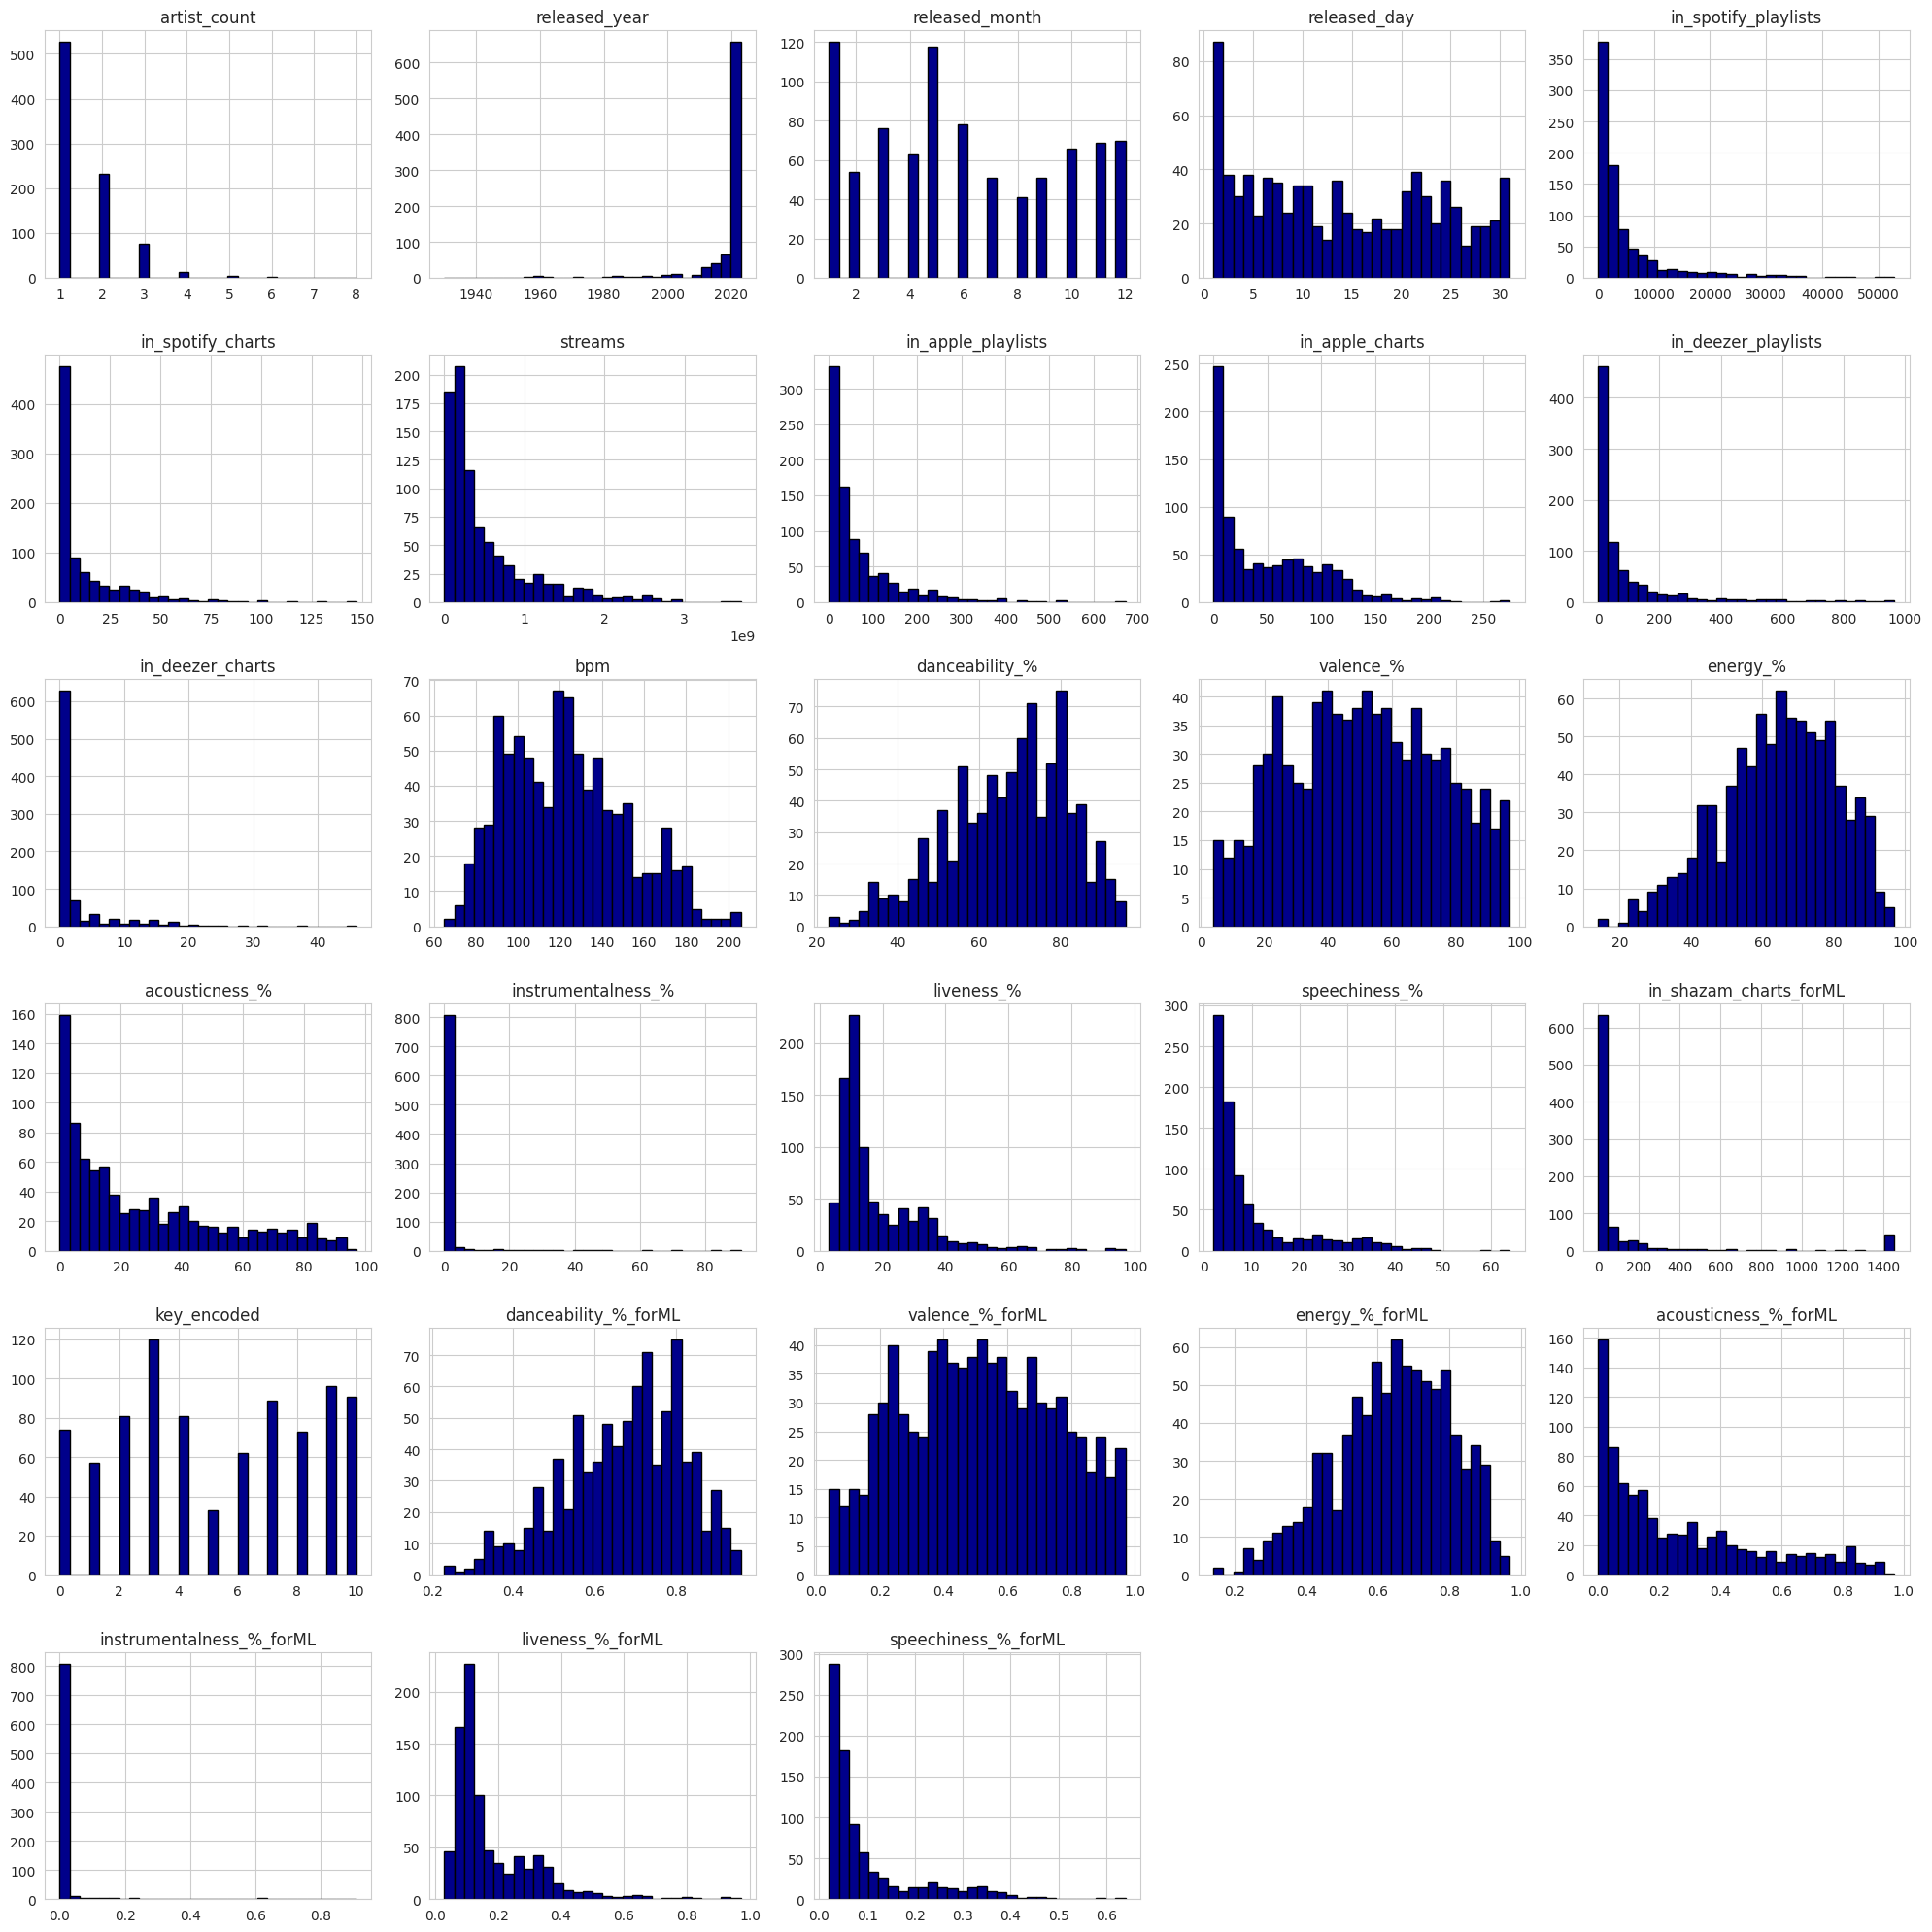

In [25]:
# Set style
sns.set_style("whitegrid")

# Plotting histograms for all numerical columns
data.select_dtypes(include=['float64', 'int64']).hist(bins=30, figsize=(20,20), color='darkblue', edgecolor='black')
plt.tight_layout()  
plt.show()


Based on the histograms, here are some key observations:

**artist_count:** Most songs are performed by a single artist, but there's a noticeable number of songs with multiple artists as well.  

**released_year:** The bulk of songs in the dataset have been released after 1980, with a very sharp increase in the number of songs released after 2000. **The peak seems to occur in the 2020s, suggesting that most of the data pertains to very recent songs.**  

**released_month:**  **January (1) and May (5) appear to be particularly popular months for song releases.** This could be due to various reasons such as industry practices or seasonal trends.  

**released_day:** There's a slight peak around the start and middle of the month, but overall, song releases are relatively distributed throughout the month.  

**in_*_playlists and in_*_charts columns:** Most songs are either not present or only appear in a few playlists or charts. However, there's a small subset of songs that seem to dominate in terms of being added to many playlists or making it to the charts.  

**bpm (beats per minute):** Songs range widely in bpm, but **there's a prominent peak around 80-100 bpm, indicating that a moderate tempo is quite popular.**  

Danceability, Valence, Energy, and other % metrics: These attributes display varying levels of skewness, but most of them, like danceability and energy, show a wide distribution indicating diverse musical properties.

**Stage 2.3: Correlation Matrix**

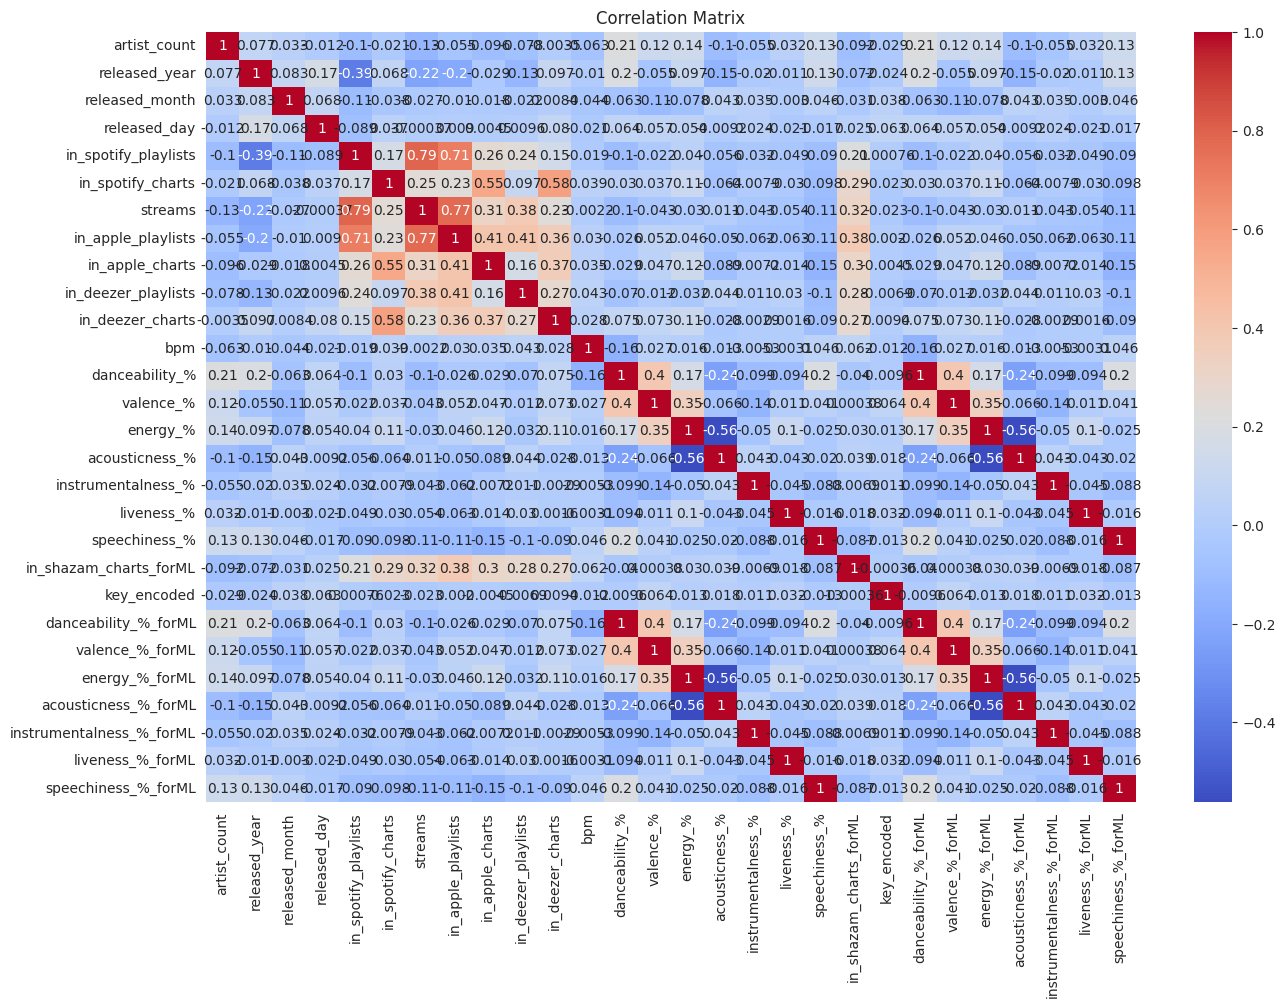

In [26]:
# Select only numeric columns
numeric_data = data.select_dtypes(include=[np.number])

# Compute the correlation matrix
correlation_matrix = numeric_data.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()



**Highly Correlated Values:**
- **danceability_% and valence_% are positively correlated.** This suggests that tracks with high danceability often have high valence, meaning they are typically more upbeat or cheerful.

- **energy_% and valence_% also show a positive correlation.** Tracks with more energy are likely to be more positive.  

**Streaming Platforms Consistency:**  
- The presence of a song in playlists for different platforms (in_spotify_playlists, in_apple_playlists, in_deezer_playlists) are moderately correlated, **indicating that tracks popular in one platform's playlists are likely to appear in another's.**

**Charts vs. Playlists:**  
- **Being in charts and being in playlists for each platform (e.g., in_spotify_playlists vs. in_spotify_charts) have positive correlations, though not extremely high.** This suggests that while songs that make it to the charts are likely to be in playlists, it's not a strict guarantee.  

**Musical Properties:**
- **bpm (beats per minute) doesn't have strong correlations with most of the other features**, implying that tempo isn't a significant driver for a song's presence in playlists or charts.

**Stage 3: Streaming Prediction(Random Forest)**

**Stage 3.1: With Default Hyperparameters**

In [27]:
cols_to_use = [
    'artist_count', 'released_year', 'released_month', 'released_day',
    'in_spotify_playlists', 'in_spotify_charts', 'in_apple_playlists', 'in_apple_charts', 
    'in_deezer_playlists', 'in_deezer_charts', 'bpm', 'danceability_%_forML', 
    'valence_%_forML', 'energy_%_forML', 'acousticness_%_forML', 'instrumentalness_%_forML', 
    'liveness_%_forML', 'speechiness_%_forML', 'key_encoded'
]

# Split the data into train-validation-test sets
X = data[cols_to_use]
y = data['streams']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Initiale and train the Random Forest Regressor
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train, y_train)

# Predict on the validation set
y_val_pred = rf_reg.predict(X_val)

# Evaluate the model
mse = mean_squared_error(y_val, y_val_pred)
mae = mean_absolute_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R^2 Score: {r2}")



Mean Squared Error (MSE): 6.381115788338408e+16
Mean Absolute Error (MAE): 161420051.23550385
R^2 Score: 0.7603237082812873


In [28]:
# Predict on the test set
y_test_pred = rf_reg.predict(X_test)

# Evaluate the model(On the test set this time)
mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Test Set Evaluation:")
print(f"Mean Squared Error (MSE): {mse_test}")
print(f"Mean Absolute Error (MAE): {mae_test}")
print(f"R^2 Score: {r2_test}")

# Retrive feature importance from the random forest model(To see which ones are important)
feature_importances = rf_reg.feature_importances_
features_df = pd.DataFrame({
    'Feature': cols_to_use,
    'Importance': feature_importances
})

print("Feature Importances:")
print(features_df.sort_values(by='Importance', ascending=False))


Test Set Evaluation:
Mean Squared Error (MSE): 7.977958133557472e+16
Mean Absolute Error (MAE): 152917993.9444961
R^2 Score: 0.8386353476945516
Feature Importances:
                     Feature  Importance
4       in_spotify_playlists    0.762848
1              released_year    0.064561
6         in_apple_playlists    0.039430
5          in_spotify_charts    0.018311
8        in_deezer_playlists    0.015847
11      danceability_%_forML    0.013038
13            energy_%_forML    0.011570
10                       bpm    0.009701
7            in_apple_charts    0.009491
14      acousticness_%_forML    0.008598
12           valence_%_forML    0.007985
3               released_day    0.007383
2             released_month    0.007058
16          liveness_%_forML    0.007002
18               key_encoded    0.006682
17       speechiness_%_forML    0.004055
9           in_deezer_charts    0.003751
15  instrumentalness_%_forML    0.001417
0               artist_count    0.001272


Features with importance values below 0.001 were considered as having negligible contribution to our model's predictive power. With this in mind, we proceeded to remove these features and retrain the model.

**Results After Feature Removal:**

The model showcased a marginal improvement, with the R^2 score increasing to **0.833.--

**Decision:**

Despite the slight enhancement in performance, we made a strategic decision to revert these changes for a couple of pivotal reasons:

1. Marginal Improvement: The improvement, though positive, was minor. Given the costs associated with feature engineering and potential risks in overfitting, the trade-offs didn't seem justifiable.  
2. Dataset Size Consideration: Given the relatively small size of our dataset, we wanted to preserve as much information as possible. This is particularly important to ensure the model's robustness when new data is introduced.

**Stage 3.2.: With Best Hyperparameters(via GridSearch)**

In [29]:
# Define the hyperparameter ranges
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize RandomForestRegressor with GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='r2')

# Fit the model
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters:", grid_search.best_params_)

# Predict using the best model
y_val_pred = grid_search.best_estimator_.predict(X_val)

# Evaluate the model's performance
mse = mean_squared_error(y_val, y_val_pred)
mae = mean_absolute_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R^2 Score: {r2}")



Fitting 3 folds for each of 216 candidates, totalling 648 fits


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors

[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.5s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.3s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.7s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END max_depth=None, ma

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors

[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=10, max_features=sqr

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors

[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, max_features=sqrt,

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors

[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.7s
[CV] END max_depth=20, max_features=

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors

[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.7s
[CV] END max_depth=20, max_features=au

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors

Best parameters: {'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 50}
Mean Squared Error (MSE): 7.000731098741705e+16
Mean Absolute Error (MAE): 170322189.46121684
R^2 Score: 0.7370508035392983


**Stage 3.2.1: Evaluation**

In [30]:
# Predict using the best model on the test set
y_test_pred = grid_search.best_estimator_.predict(X_test)

# Evaluate the model's performance on the test set
mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Test Set Evaluation:")
print(f"Mean Squared Error (MSE): {mse_test}")
print(f"Mean Absolute Error (MAE): {mae_test}")
print(f"R^2 Score: {r2_test}")


Test Set Evaluation:
Mean Squared Error (MSE): 7.039977134419889e+16
Mean Absolute Error (MAE): 152741243.75295496
R^2 Score: 0.8576072419137385


**Stage 3.2.2: Feature Importances**

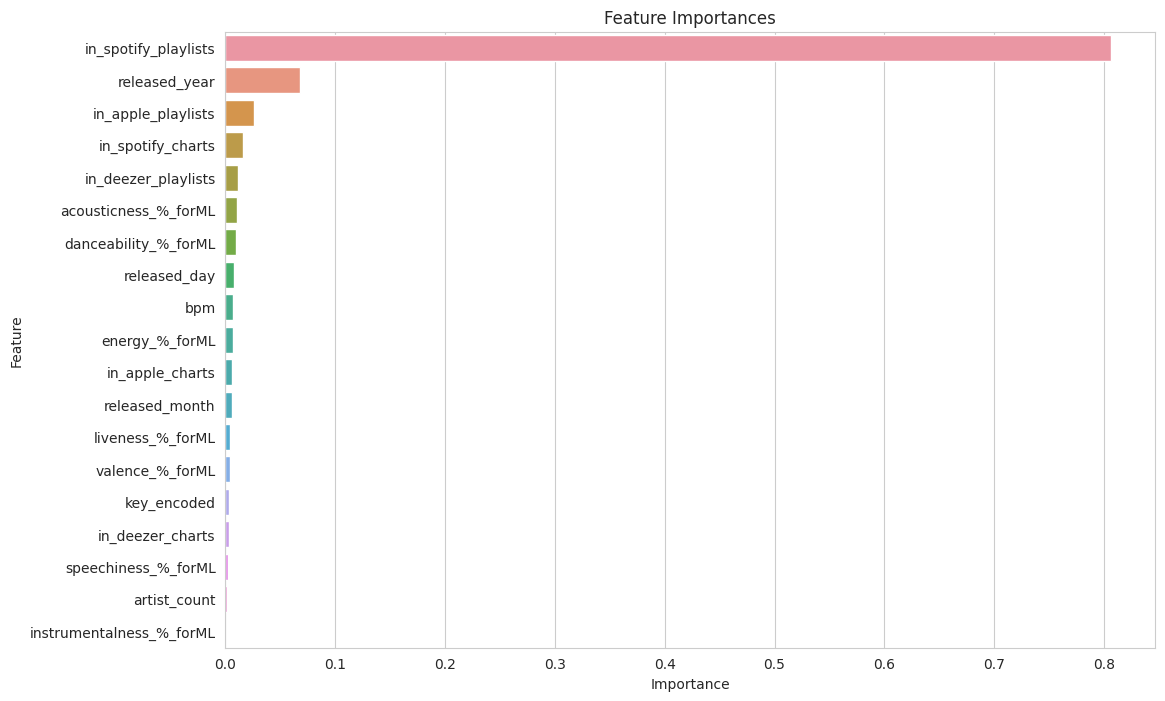

In [31]:
# Extract feature importances from the trained Random Forest model
importances = grid_search.best_estimator_.feature_importances_
features = cols_to_use

# Create a DataFrame for the importances and plot
df_importances = pd.DataFrame({'Feature': features, 'Importance': importances})
df_importances = df_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=df_importances)
plt.title('Feature Importances')
plt.show()


**Stage 3.2.3: Actual vs. Predicted Streams**

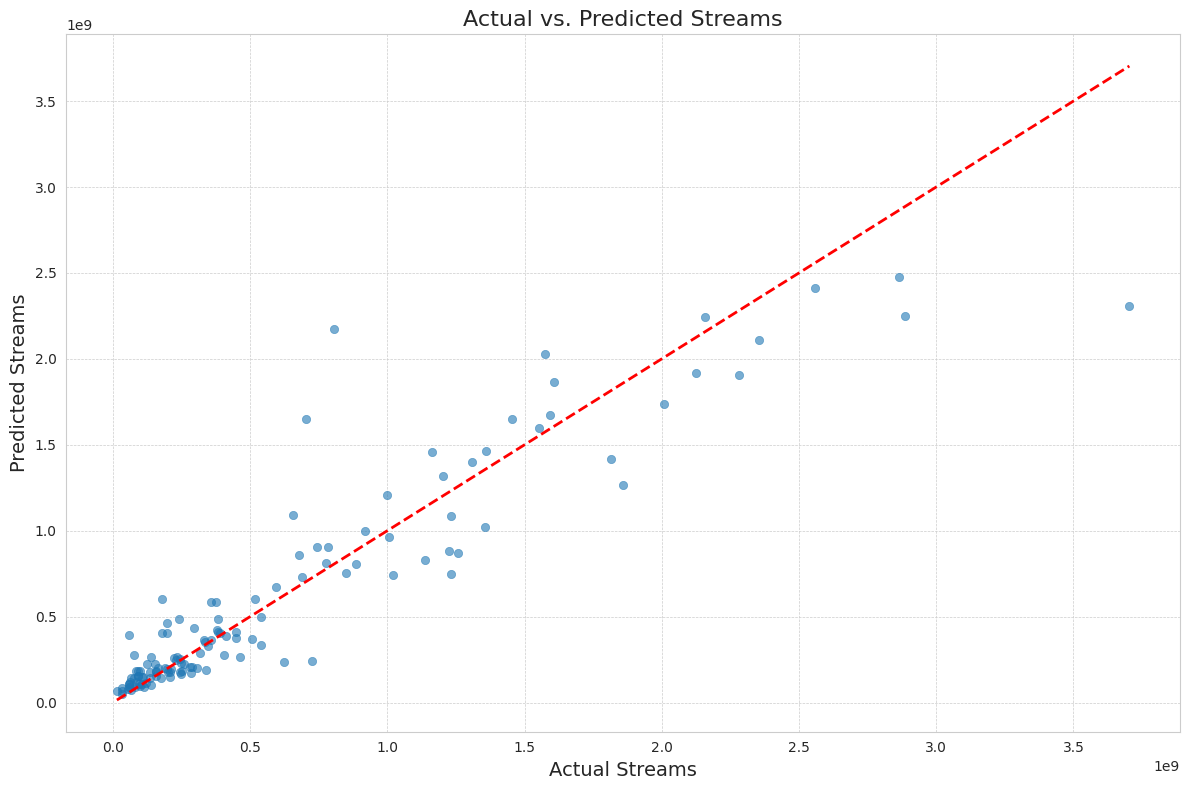

In [32]:
# Actual vs. Predicted Streams
plt.figure(figsize=(12, 8))
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.6, edgecolor=None)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', lw=2)
plt.xlabel('Actual Streams', fontsize=14)
plt.ylabel('Predicted Streams', fontsize=14)
plt.title('Actual vs. Predicted Streams', fontsize=16)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()



**Stage 3.2.4: Residuals vs. Predicted Streams**

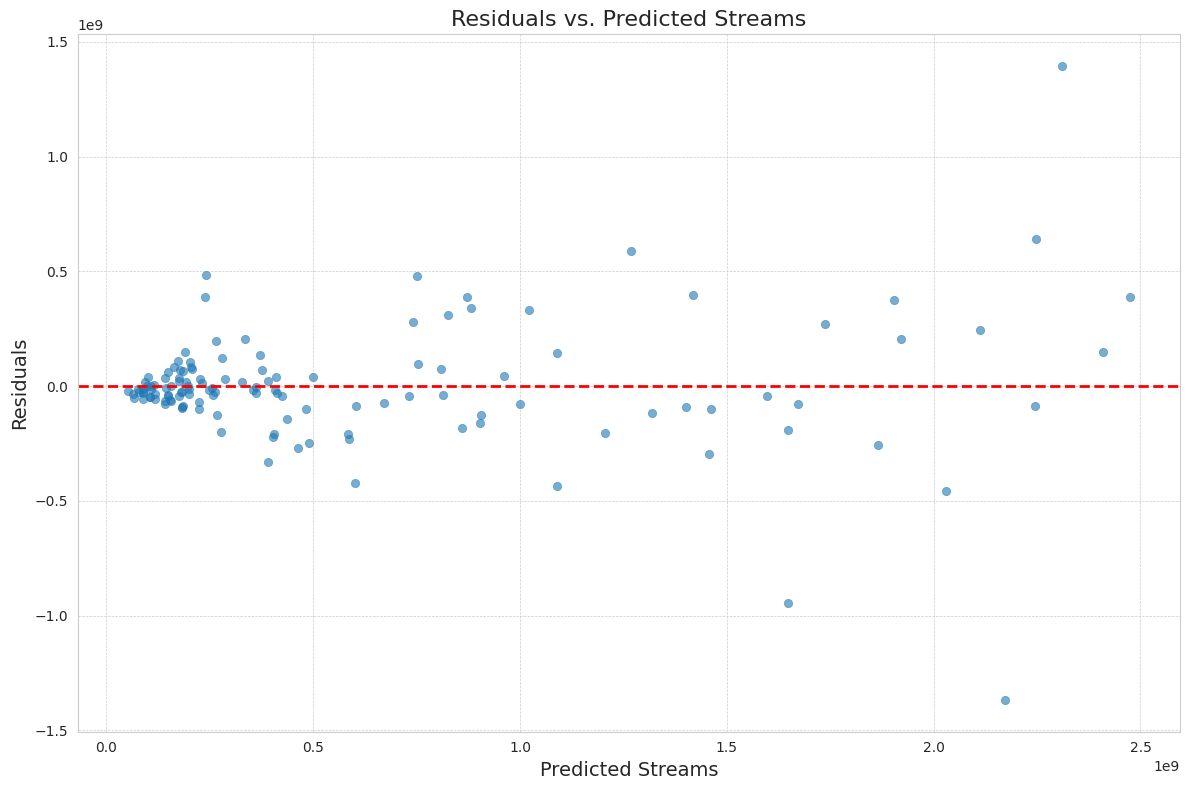

In [33]:
# Plot the residuals against predicted streams to assess model accuracy.
residuals = y_test - y_test_pred
plt.figure(figsize=(12, 8))
sns.scatterplot(x=y_test_pred, y=residuals, alpha=0.6, edgecolor=None)
plt.axhline(0, color='red', linestyle='--', lw=2)
plt.xlabel('Predicted Streams', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.title('Residuals vs. Predicted Streams', fontsize=16)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()



**Stage 3.2.5: Distribution of Streams**

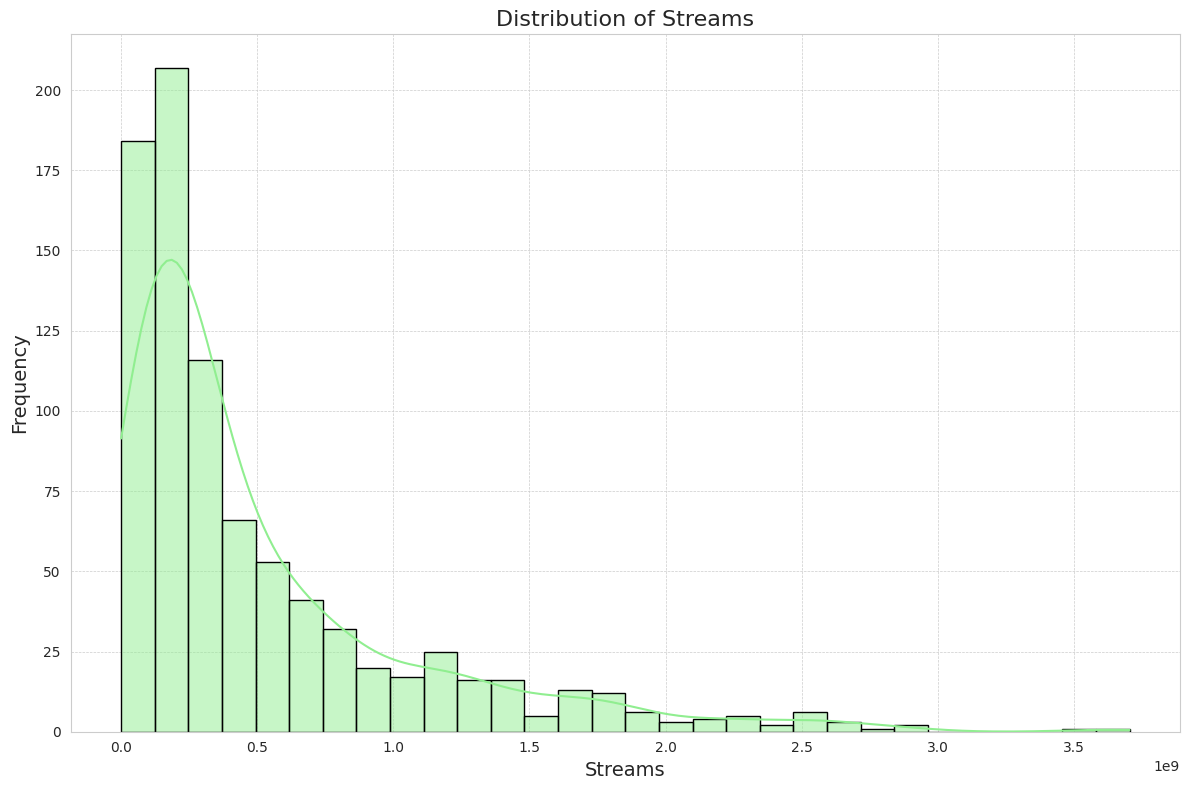

In [34]:
plt.figure(figsize=(12, 8))
sns.histplot(data['streams'], kde=True, color='lightgreen', edgecolor='black', bins=30)
plt.title('Distribution of Streams', fontsize=16)
plt.xlabel('Streams', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()




